# Comparison of a rule-based(VADER) method and a machine-learning method (DistillBERT) in sentiment analysis

This notebook aims to perform comparative sentiment analysis on textual IMDB movie reviews using a machine-learning-based approach and a rule-based approach. As the rule-based approach, VADER lexicon-based algorithm is chosen and as the machine learning-based approach DistillBERT is used.
The motivation behind choosing VADER is that based on this research (Hutto & Gilbert, 2014), in which it outperformed all other conventional lexicon-based algorithms. In addition, BERT has shown great performance in sentiment analysis (Alaparthi & Mishra, 2021) and DistillBERT, is the cheaper and faster version of BERT while preserving over 95% of BERT’s performance (DistilBERT, 2023). DistilBERT also showed better performance (accuracy score of 91.46%) in sentiment analysis of tweets regarding COVID-19-related hashtags on Twitter(Ranganathan & Tsahai, 2022).

## Importing the libraries

In [ ]:
# data exploration and base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

# model selection module to split the data
from sklearn.model_selection import train_test_split

# text cleaning modules and libraries
import bs4
from bs4 import BeautifulSoup
import re
import nltk

# libraries and modules for applying nlp tasks
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')

# libraries and modules to import models
import transformers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# modules to measure the performance of models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### finding the version of each library

In [ ]:
python_version = !python --version
print("python version: ", python_version[0])
print("nltk library version: ", nltk.__version__)
print( "tensorflow and keras versions are: ", keras. __version__, tf.__version__)
print("bs4 library version is", bs4.__version__)
print("re library version is", re.__version__)
print("transformers library version is", transformers.__version__)

python version:  Python 3.10.12
nltk library version:  3.8.1
tensorflow and keras versions are:  2.15.0 2.15.0
bs4 library version is 4.11.2
re library version is 2.2.1
transformers library version is 4.35.2


## Data Exploration

In [ ]:
# importing the data to a pandas dataframe
data = pd.read_csv("/content/sample_data/IMDB_MovieReviewDataset.csv")

In [ ]:
# showing the first 5 rows
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


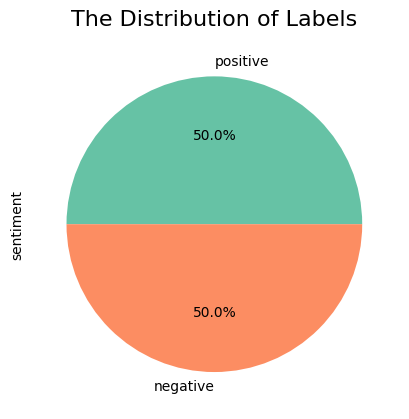

positive    25000
negative    25000
Name: sentiment, dtype: int64


In [ ]:
data['sentiment'].value_counts().plot.pie(autopct = "%.01f%%", labels = data.sentiment.unique(),colors=sns.color_palette('Set2'))
plt.title(label="The Distribution of Labels", fontdict={"fontsize":16},pad=10)
plt.show()
print(data['sentiment'].value_counts())

* There are 25000 positive and 25000 negative labels. So, the dataset is completely balanced and doesn't require techniques applied to imbalanced datasets.

In [ ]:
# showing the first five review completely as an example
for i in range(5):
  print(data.iloc[i,0],"\n")

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

* **ideas for text cleaning:** As it appears, there are some HTML tags like <br /> in the rviews that need to be removed.Also there are some punctuation errors like "to many..Aryans"(using two dots at the end of sentence).

In the following steps, I go through the preprocessing steps:


1.   first, removal of HTML, style and script tags
2.   Then, removal of special characters using re library and r'[^a-zA-z0-9\s]' pattern
3. lemmatizing the words
4. removing stopwords


# Text Pre-processing

**Step 1: Cleaning the html tags, style and script signs**




In [ ]:
#Removing the html strips
def html_tags_removal(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def square_brackets_removal(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def sings_removal(text):
    text = html_tags_removal(text)
    text = square_brackets_removal(text)
    return text
#Apply function on review column
data['step1_tag_removal']=data['review'].apply(sings_removal)

<ipython-input-11-521c0fc284fc>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
# inspecting the changes
print("raw text:\n", data.iloc[1]["review"],"\nafter html tags removal:\n",data.iloc[1]["step1_tag_removal"])

raw text:
 A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly w

As It appears, the html tags in "<'br /><'br />The filming technique...." are removed.

**Step 2: Cleaning the special characthers**

Special characters are like punctuation charcters(comma, quotation, double quotation, ... ), dash(-), underline(_), and ....

In [ ]:
# define a function for removing special characters
def special_characters_removal(text):
    pattern=r'[^a-zA-z0-9\.\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
data['step2_special_char_removal']=data['step1_tag_removal'].apply(special_characters_removal)

In [ ]:
# inspecting the changes
print("before removing special charachters:\n", data.iloc[1]["step1_tag_removal"],"\nafter removing special characters:\n",data.iloc[1]["step2_special_char_removal"])

before removing special charachters:
 A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.

here are some changes before --> after:


1.   old-time-BBC --> oldtimeBBC
2.   , and sometimes discomforting, --> and sometimes discomforting
3. Williams' diary entries --> Williams diary entries





**Step 3: Word Lemmatization (and lower-casing)**

Word lemmatization is a technique that involves reducing words to their base or root form, known as the "lemma." The purpose of lemmatization is to normalize words, so that variations of a word (like plurals or different verb tenses) are mapped to a single common form.

In [ ]:
# creating a lemmatizer class using nltk's wordnet lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatizing the text
def simple_lemmatizer(text):
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word.lower()) for word in text.split()])
    return lemmatized_text

# applying the function on cleaned data
data['step3_word_lemma']=data['step2_special_char_removal'].apply(simple_lemmatizer)

In [ ]:
# inspecting the changes
print("before applying word lemmatization:\n", data.iloc[1]["step2_special_char_removal"],"\nafter applying word lemmatization:\n",data.iloc[1]["step3_word_lemma"])

before applying word lemmatization:
 A wonderful little production. The filming technique is very unassuming very oldtimeBBC fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece. The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great masters of comedy and his life. The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears. It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwells murals decorating every surface are terribly well done. 
after applying word

**Step 4: Removing stop words**

Stop words are words that happen highly frequently in documents and do not contribute to the meaning, like "a", "the", "is", "are", ...

In [ ]:
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

stop=set(stopwords.words('english'))
#Tokenization of text
tokenizer=ToktokTokenizer()


In [ ]:
#removing the stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#Apply function on review column
data['step4_stopword_removed']=data['step3_word_lemma'].apply(remove_stopwords)

In [ ]:
# inspecting the changes
print("before applying stopwords removal:\n",
      data.iloc[1]["step3_word_lemma"],"\nafter applying stopword removal:\n",
      data.iloc[1]["step4_stopword_removed"])

before applying stopwords removal:
 a wonderful little production. the filming technique is very unassuming very oldtimebbc fashion and give a comforting and sometimes discomforting sense of realism to the entire piece. the actor are extremely well chosen michael sheen not only ha got all the polari but he ha all the voice down pat too you can truly see the seamless editing guided by the reference to williams diary entry not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master of comedy and his life. the realism really come home with the little thing the fantasy of the guard which rather than use the traditional dream technique remains solid then disappears. it play on our knowledge and our sens particularly with the scene concerning orton and halliwell and the set particularly of their flat with halliwells mural decorating every surface are terribly well done. 
after applying stopword removal:
 wond

Here are some example changes before and after removing stopwords:


*   "the filming technique" --> "filming technique"
*   "is very" --> removed completely
*   "give a comforting" --> "give comforting"



# BERT

In [ ]:
# changing the labels into ineger
data["sentiment_int"] = data["sentiment"].apply(lambda x: 1 if x == 'positive' else 0)

# creating a list of features(X) and labels(y)
X = data["step4_stopword_removed"].tolist()
y = data["sentiment_int"].tolist()

In [ ]:
# splitting the data into train-validation-test sets (35%-15%-50%) -->(17,500-7,500,25,000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [ ]:
# checking the length of train, validation, and test sets
print("trainging set length ",len(X_train),
      "\nvalidation set length", len(X_val),
      "\ntest set length", len(X_test))

trainging set length  17500 
validation set length 7500 
test set length 25000


In [ ]:
# importing DistilBertTokenizerFast class from the Hugging Face Transformers library
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# converting input strings to BERT encodings
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True,  max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
# transforming the encodings to tf.data.datset objects, shuffling them, turning them to batches of 16 for the training set
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(16)

# for the validation and test set, I just create batches of 64
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(64)

In [ ]:
labels = ['positive','negative']
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased',
                                                           num_labels=len(labels))
callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0,
                      mode='min', baseline=None,
                      restore_best_weights=True)]

baseline_optimizer = 'adam'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=baseline_optimizer, loss=loss)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model.fit(train_dataset,
            epochs=10,
          callbacks=callbacks,
          validation_data=val_dataset)

Epoch 1/10
1094/1094 [==============================] - 291s 247ms/step - loss: 0.6963 - val_loss: 0.6931
Epoch 2/10
1094/1094 [==============================] - 258s 236ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/10
1094/1094 [==============================] - 247s 226ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/10
1094/1094 [==============================] - 246s 225ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/10
1094/1094 [==============================] - 248s 227ms/step - loss: 0.6955 - val_loss: 0.6931


As it shows, model's performance on the validation set got locked on 69.3%, which cauased the early stopping call back stop it after 4 patience epochs. In the next phase, I create another model and test it with a lower learning rate.

**Creating the second model with a lower learning rate**

In [ ]:
# creating the second optimizer using Adam and a lower learning rate
lower_lr_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased',
                                                           num_labels=len(labels))
model2.compile(optimizer=lower_lr_optimizer, loss=loss)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# fitting the second model with lower learning rate to the training set
hisotry_lower_lr = model2.fit(train_dataset,
            epochs=10,
          callbacks=callbacks,
          validation_data=val_dataset)

Epoch 1/10
1094/1094 [==============================] - 274s 234ms/step - loss: 0.4283 - val_loss: 0.3624
Epoch 2/10
1094/1094 [==============================] - 265s 242ms/step - loss: 0.2777 - val_loss: 0.3430
Epoch 3/10
1094/1094 [==============================] - 270s 246ms/step - loss: 0.1685 - val_loss: 0.4242
Epoch 4/10
1094/1094 [==============================] - 259s 237ms/step - loss: 0.1125 - val_loss: 0.6132
Epoch 5/10
1094/1094 [==============================] - 264s 241ms/step - loss: 0.0720 - val_loss: 0.5864
Epoch 6/10
1094/1094 [==============================] - 258s 236ms/step - loss: 0.0588 - val_loss: 0.5117


<Axes: >

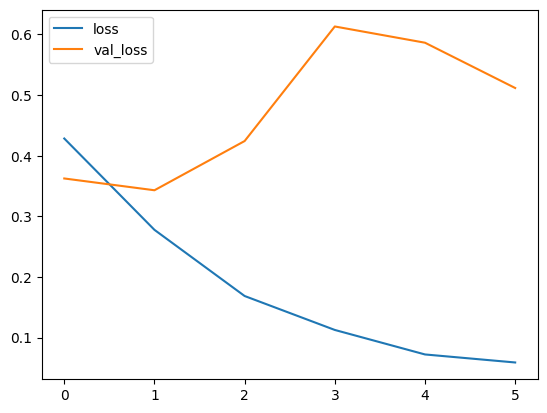

In [ ]:
# showing the loss curve of the second model
model_performance = pd.DataFrame(hisotry_lower_lr.history)
model_performance[['loss','val_loss']].plot()

In [ ]:
# finding the predicted labels of the test set
logits = model2.predict(test_dataset)
y_preds = np.argmax(logits[0], axis=1)

391/391 [==============================] - 101s 255ms/step


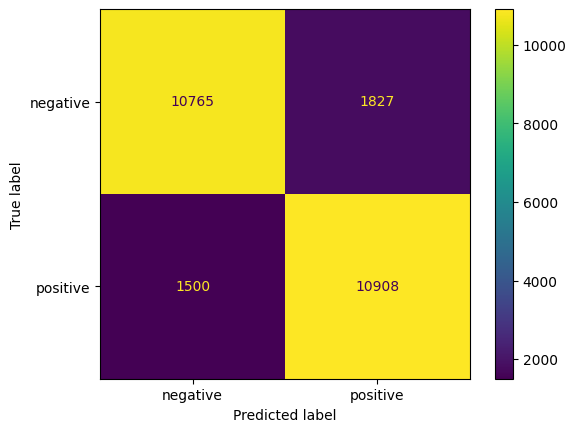

In [ ]:
# showing the confusion matrix of the second model
distillbert_cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=distillbert_cm,
                            display_labels=['negative','positive'])
disp.plot()
plt.show()

In [ ]:
# showing the model's performance report(f1, precision, accuracy and recall scores)
print(classification_report(y_test, y_preds,target_names=['negative','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.878     0.855     0.866     12592
    positive      0.857     0.879     0.868     12408

    accuracy                          0.867     25000
   macro avg      0.867     0.867     0.867     25000
weighted avg      0.867     0.867     0.867     25000



# Sentiment Analysis using VADER

At the beginning, I need to create a dataframe from the test set of the DistillBERT model (to compare results by using the same datasets)

In [ ]:
X_test_df = pd.DataFrame(X_test, columns = ["step4_stopword_removed"])
X_train_df = pd.DataFrame(X_train, columns = ["step4_stopword_removed"])
X_test_df.head()

,step4_stopword_removed
0,dead hero get stupid line like woefully abysma...
1,thought maybe ... maybe could good. early appe...
2,elite american military team course happens in...
3,ridiculous horror film wealthy man john carrad...
4,well one katanas filmnuts like sure appreciate...


VADER provides a compound score for each sentence. Based on this score and pre-defined thresholds, the sentiment of each review is determined. The point here is that in the default recommended thresholds, 'neutral' sentiments are considered, while in this dataset we don't have any neutral thresholds. In such scenarios, It is recommended to use 0 as the determining threshold or search for the best values that fit on our data. As a result, for the training phase, I test different thresholds on the training set for assigning reviews to the negative and positive sentiments.

The default thresholds are as below:
* positive sentiment: compound score >= 0.5
* neutral sentiment: (compound score > -0.5) and (compound score < 0.5)
* negative sentiment: compound score <= -0.5

In [ ]:
sia = SentimentIntensityAnalyzer()
X_train_df["vader_component_value"] = X_train_df["step4_stopword_removed"].apply(lambda x: sia.polarity_scores(x)['compound'])
X_train_df.head()

,step4_stopword_removed,vader_component_value
0,maybe wa fact saw spiderman day saw duce wild ...,0.7003
1,first started watching movie wa looking kind s...,0.9119
2,saw movie hallmark channel thought wa wonderfu...,0.9815
3,best thing say quintet quite bad remembered fi...,0.8617
4,prc wa lowest low actually struck gold moody l...,-0.9712


Now, I test different thresholds for the component threshold and choose the best one based on accuracy score:

In [ ]:
np.arange(-5.0,6.0,1.0)/10

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

In [ ]:
threshold_inspection = {'threshold' : [], 'accuracy_score' : []}
for i in np.arange(-5,6,1)/10:
    y_pred_threshold = X_train_df["vader_component_value"].apply(lambda x: 1 if x >= i else 0).values
    accuracy = np.round(accuracy_score(y_train, y_pred_threshold),2)
    threshold_inspection['accuracy_score'].append(accuracy)
    threshold_inspection['threshold'].append(i)

print("list of thresholds ",threshold_inspection['threshold'],
      "\nlist of accuracy scores",threshold_inspection['accuracy_score'] )

list of thresholds  [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5] 
list of accuracy scores [0.64, 0.65, 0.65, 0.66, 0.67, 0.67, 0.67, 0.68, 0.68, 0.69, 0.69]


0.5 showed a better accuracy score, so I choose it as the final threshold to determine the sentiment of reviewes.

In [ ]:
# applying the VADER polarity scorer function to the reviews, using 0.5 as the threshold
%%timeit
X_test_df['vader_pred'] = X_test_df["step4_stopword_removed"].apply(lambda x: 1 if sia.polarity_scores(x)['compound'] >= 0.5 else 0)


47.9 s ± 1.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Results are ready, now it's time to represent the confusion matrix and results:

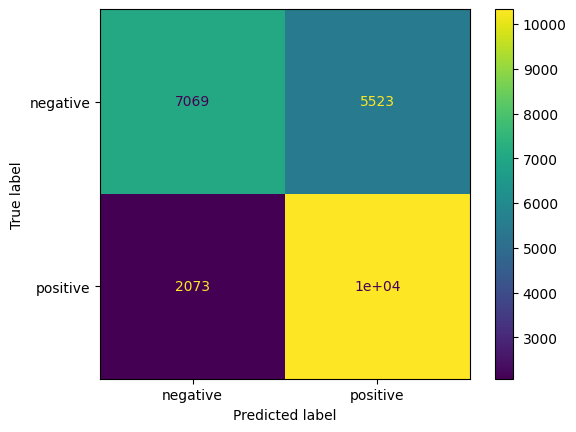

In [ ]:
# showing the confusion matrix
vader_cm = confusion_matrix(y_test, X_test_df['vader_pred'].values)
disp = ConfusionMatrixDisplay(confusion_matrix=vader_cm,
                            display_labels=['negative','positive'])
disp.plot()
plt.show()

In [ ]:
# finding the precision,recall, and f1-score of the classificatio
print(classification_report(np.array(y_test), X_test_df['vader_pred'].values,target_names=['negative','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.773     0.561     0.651     12592
    positive      0.652     0.833     0.731     12408

    accuracy                          0.696     25000
   macro avg      0.712     0.697     0.691     25000
weighted avg      0.713     0.696     0.691     25000



### References:


*   Hutto, C., & Gilbert, E. (2014). Vader: A parsimonious rule-based model for sentiment analysis of social media text. Paper presented at the Proceedings of the international AAAI conference on web and social media.
*   Alaparthi, S., & Mishra, M. (2021). BERT: A sentiment analysis odyssey. Journal of Marketing Analytics, 9(2), 118-126.
* DistilBERT. (2023). DistilBERT. Retrieved from https://huggingface.co/docs/transformers/model_doc/distilbert
* Ranganathan, J., & Tsahai, T. (2022). Sentiment Analysis of Tweets Using Deep Learning. Paper presented at the International Conference on Advanced Data Mining and Applications.

